In [ ]:
import os
import json
import csv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import sklearn.metrics
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import seaborn as sns

Para este caso, tenemos nuestro directorio de la siguiente manera:
* /data
  * /APT1
    * apt1file_1
    * apt1file_2
    * ...
  * /crypto
    * cryptofile_1
    * cryptofile_2
    * ...
  * /locker
    * lockerfile_1
    * lockerfile_2
    * ...
  * /zeus
    * zeusfile_1
    * zeusfile_2
    * ...

In [ ]:
os.listdir('/content/drive/MyDrive/4to año/2do Cuatrimestre/TFG/Materiales/detección del malware/data')

['APT1', 'zeus', 'crypto', 'locker']

Guardamos los nombres de los ficheros en un array correspondiente a cada uno.

In [ ]:
apt1_filenames = []
for file in sorted(os.listdir('/content/drive/MyDrive/4to año/2do Cuatrimestre/TFG/Materiales/detección del malware/data/APT1')):
  if not file.startswith('.'):
    apt1_filenames.append(file)

In [ ]:
crypto_filenames = []
for file in sorted(os.listdir('/content/drive/MyDrive/4to año/2do Cuatrimestre/TFG/Materiales/detección del malware/data/crypto')):
  if not file.startswith('.'):
    crypto_filenames.append(file)

In [ ]:
locker_filenames = []
for file in sorted(os.listdir('/content/drive/MyDrive/4to año/2do Cuatrimestre/TFG/Materiales/detección del malware/data/locker')):
  if not file.startswith('.'):
    locker_filenames.append(file)

In [ ]:
zeus_filenames = []
for file in sorted(os.listdir('/content/drive/MyDrive/4to año/2do Cuatrimestre/TFG/Materiales/detección del malware/data/zeus')):
  if not file.startswith('.'):
    zeus_filenames.append(file)

Con los nombres de los ficheros, podemos ahora cargarlos y leerlos. Los almacenamos, cada tipo, en un array diferente. 

In [ ]:
def load_files(category, filename):
  if category=='apt1':
    directory = '/content/drive/MyDrive/4to año/2do Cuatrimestre/TFG/Materiales/detección del malware/data/APT1'
  elif category=='crypto':
    directory = '/content/drive/MyDrive/4to año/2do Cuatrimestre/TFG/Materiales/detección del malware/data/crypto'
  elif category=='locker':
    directory = '/content/drive/MyDrive/4to año/2do Cuatrimestre/TFG/Materiales/detección del malware/data/locker'
  elif category=='zeus':
    directory = '/content/drive/MyDrive/4to año/2do Cuatrimestre/TFG/Materiales/detección del malware/data/zeus'
  with open(os.path.join(directory, filename)) as f:
    file = json.loads(f.read())
    return file
    
apt1_files = [load_files('apt1', filename=name) for name in apt1_filenames]
crypto_files = [load_files('crypto', filename=name) for name in crypto_filenames]   
locker_files = [load_files('locker', filename=name) for name in locker_filenames]   
zeus_files = [load_files('zeus', filename=name) for name in zeus_filenames]   

Mostramos la cantidad de ficheros de cada tipo que hay:

In [ ]:
print("Amount of apt1 files: ", len(apt1_files))
print("Amount of crypto files: ", len(crypto_files))
print("Amount of locker files: ", len(locker_files))
print("Amount of zeus files: ", len(zeus_files))

Amount of apt1 files:  292
Amount of crypto files:  1520
Amount of locker files:  431
Amount of zeus files:  2159


Mostramos la estructura de los ficheros:

In [ ]:
## Keys:
print(apt1_files[0].keys())
print(crypto_files[0].keys())
print(locker_files[0].keys())
print(zeus_files[0].keys())

dict_keys(['entityId', 'entityType', 'event', 'eventTime', 'properties'])
dict_keys(['entityId', 'entityType', 'event', 'eventTime', 'properties'])
dict_keys(['entityId', 'entityType', 'event', 'eventTime', 'properties'])
dict_keys(['entityId', 'entityType', 'event', 'eventTime', 'properties'])


In [ ]:
print(zeus_files[0]['properties'].keys())

dict_keys(['file_access', 'pe_imports', 'sig_clamav', 'sig_process_needed', 'pe_sec_character', 'sig_antivirus_virustotal', 'cmd_exec', 'api_resolv', 'pe_sec_entropy', 'pe_sec_name', 'sig_packer_entropy', 'sig_packer_upx', 'label', 'mutex_access', 'sig_injection_rwx', 'file_read', 'sig_static_pe_anomaly', 'sig_copies_self', 'sig_dropper', 'file_drop', 'file_write', 'str', 'sig_origin_resource_langid'])


El valor interesante está en la columna de "properties". Los datos de esta columna varían según el tipo de malware, y los de un mismo tipo tampoco coinciden completamente. 

Para ver qué propiedades hay en cada tipo de malware creamos un array para cada tipo, y guardamos todas las propiedades de cada malware. También guardamos las propiedades comunes. 

In [ ]:
## Get properties of each malware type
properties_apt1 = []
properties_crypto = []
properties_locker = []
properties_zeus = []

for file in apt1_files:
  for prop in file['properties']:
    if (prop not in properties_apt1):
      properties_apt1.append(prop)

for file in crypto_files:
  for prop in file['properties']:
    if (prop not in properties_crypto):
      properties_crypto.append(prop)


for file in locker_files:
  for prop in file['properties']:
    if (prop not in properties_locker):
      properties_locker.append(prop)
    

for file in zeus_files:
  for prop in file['properties']:
    if (prop not in properties_zeus):
      properties_zeus.append(prop)


## Get common properties
properties = []
for prop in properties_apt1:
  if (prop in properties_crypto and prop in properties_locker and properties_zeus):
    properties.append(prop)

Mostramos las propiedades de cada malware y la cantidad. 

In [ ]:
print("Number of APT1 files properties: ", len(properties_apt1))
properties_apt1.sort()
print("APT1 files properties: ", properties_apt1)
print("\n")
print("Number of Crypto files properties: ", len(properties_crypto))
print("Crypto files properties: ", properties_crypto)
print("\n")
print("Number of Locker files properties: ", len(properties_locker))
print("Locker files properties: ", properties_locker)
print("\n")
print("Number of Zeus files properties: ", len(properties_zeus))
print("Zeus files properties: ", properties_zeus)
print("\n\n")
print("Number of common properties: ", len(properties))
print("Common properties: ", properties)

Number of APT1 files properties:  59
APT1 files properties:  ['api_resolv', 'cmd_exec', 'file_access', 'file_delete', 'file_drop', 'file_read', 'file_write', 'label', 'mutex_access', 'net_con', 'net_dns', 'net_http', 'pe_imports', 'pe_sec_character', 'pe_sec_entropy', 'pe_sec_name', 'reg_access', 'reg_delete', 'reg_read', 'reg_write', 'service_create', 'service_start', 'sig_antiav_servicestop', 'sig_antimalware_metascan', 'sig_antisandbox_sleep', 'sig_antivirus_virustotal', 'sig_antivm_generic_disk', 'sig_bypass_firewall', 'sig_clamav', 'sig_copies_self', 'sig_deletes_self', 'sig_dropper', 'sig_encrypted_ioc', 'sig_exec_crash', 'sig_fraudguard_threat_intel_api', 'sig_injection_createremotethread', 'sig_injection_rwx', 'sig_modifies_certs', 'sig_modify_proxy', 'sig_multiple_useragents', 'sig_network_cnc_http', 'sig_network_http', 'sig_office_security', 'sig_origin_langid', 'sig_origin_resource_langid', 'sig_packer_entropy', 'sig_packer_vmprotect', 'sig_persistence_autorun', 'sig_persist

Vemos las diferentes propiedades que tienen cada uno de los tipos de malware. Sin embargo, por ejemplo, la propiedad "api_resolv" no la tienen **todos** los ficheros malware del tipo APT1. 

Por lo tanto, lo primero que haremos será agrupar los valores de todas las propiedades que tenga cada fichero en una sola columna.

Comenzamos a crear el dataset. 

In [ ]:
## create dataset
dataset = [['properties', 'label']]

Para cada fichero, almacenamos todas las propiedades que contenga dicho fichero y el tipo de malware que es. 

In [ ]:
def append_file(file, target):
  row = []

  props_string = ''
  for prop in file['properties']:
    if prop != 'label': # label indica el tipo de malware que es
      props_string = props_string + ' ' + file['properties'][prop]
  row.append(props_string)

  row.append(target)

  dataset.append(row)

In [ ]:
for file in apt1_files:
  append_file(file, 0)

for file in crypto_files:
  append_file(file, 1)

for file in locker_files:
  append_file(file, 2)

for file in zeus_files:
  append_file(file, 3)
  

with open('malware_dataset.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for row in dataset: 
      writer.writerow(row)

Ahora ya tenemos el dataset creado. 

In [ ]:
df = pd.read_csv("/content/malware_dataset.csv")
df.head()

,properties,label
0,d5197d93 c3581516 45b96339 45b96339 0976bdd4 ...,0
1,d5197d93 c3581516 45b96339 45b96339 0976bdd4 ...,0
2,4a4212d1 05bc38e9 b7b66a05 af5cc73b 4bd26db0 ...,0
3,3d801aa5 385273e4 98e83379 2e5d8aa3 385273e4 ...,0
4,3d801aa5 350fd223 98e83379 bda9f42e 249a6812 ...,0


In [ ]:
df.label.value_counts()

3    2159
1    1520
2     431
0     292
Name: label, dtype: int64

Definimos la variable predictora y la objetivo. 

In [ ]:
predictor = df.properties
target = df.label
target.unique()

array([0, 1, 2, 3])

Creamos la muestra de entrenamiento y de test, siendo test el 20% de la muestra total.

In [ ]:
pred_train, pred_test, tar_train, tar_test = train_test_split(predictor, target,  test_size=.2)

A continuación podemos ver la cantidad de ficheros que tenemos de cada tipo para la muestra de entrenamiento y de test. 

In [ ]:
# Data for training
pos, count = np.unique(tar_train,return_counts=True)
for i, p in enumerate(pos):
    print(p,"=",count[i])

apt1 = 198
crypto = 288
locker = 303
zeus = 244


In [ ]:
# Data for testing
pos, count = np.unique(tar_test,return_counts=True)
for i, p in enumerate(pos):
    print(p,"=",count[i])

apt1 = 51
crypto = 107
locker = 107
zeus = 80


**NAIVE BAYES**

In [ ]:
naivebayes = Pipeline([('cv', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('nb', MultinomialNB()),
])

naivebayes.fit(pred_train, tar_train)

predictions = naivebayes.predict(pred_test)


CONFUSION MATRIX


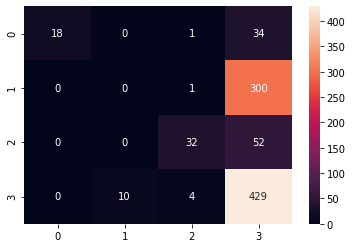

In [ ]:
# creating confusing matrix

con_mat = confusion_matrix(tar_test,predictions)

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d')

In [ ]:
#Sacamos el índice Accuracy Score, que resume la Matriz de Confusión y la cantidad de aciertos.
print("Accuracy score: ", sklearn.metrics.accuracy_score(tar_test, predictions))

Accuracy score:  0.5255391600454029


**RANDOM FOREST**


CONFUSION MATRIX


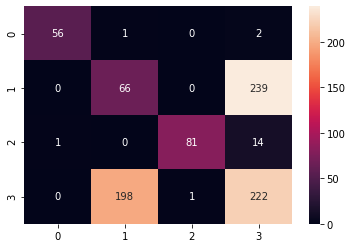

In [ ]:
randomforest = Pipeline([('cv', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('rf', RandomForestClassifier(n_estimators=10)),
])

randomforest.fit(pred_train, tar_train)

predictions = randomforest.predict(pred_test)

# creating confusing matrix
con_mat = confusion_matrix(tar_test,predictions)

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d')

In [ ]:
#Sacamos el índice Accuracy Score, que resume la Matriz de Confusión y la cantidad de aciertos.
print("Accuracy score: ", sklearn.metrics.accuracy_score(tar_test, predictions))

Accuracy score:  0.48240635641316687


**REGRESIÓN LOGÍSTICA**


CONFUSION MATRIX


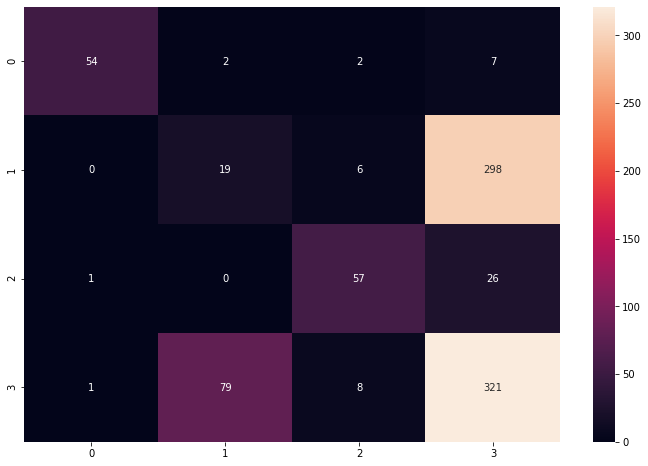

In [ ]:
reglog = Pipeline([('cv', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('lr', LogisticRegression(solver="liblinear", random_state=42)),
])

reglog.fit(pred_train, tar_train)

predictions = reglog.predict(pred_test)

# creating confusing matrix
con_mat = confusion_matrix(tar_test,predictions)

print('\nCONFUSION MATRIX')
plt.figure(figsize= (12,8))
sns.heatmap(con_mat, annot = True,fmt='d')

In [ ]:
#Sacamos el índice Accuracy Score, que resume la Matriz de Confusión y la cantidad de aciertos.
print("Accuracy score: ", sklearn.metrics.accuracy_score(tar_test, predictions))

Accuracy score:  0.5119182746878547


Como vemos, los resultados no son muy buenos. Entonces lo que haremos es analizar de otra forma las properties de cada malware y crear un nuevo dataset.

Lo que haremos será obtener todas las properties que son comunes en todos los ficheros de un mismo tipo de malware. 

In [ ]:
def interseccion(a, b):
    lista_final = []
    for i in a:
        if (i not in lista_final) and (i in b):
            lista_final.append(i)
    return lista_final

In [ ]:
## Get properties of each malware type
properties_apt1 = apt1_files[0]['properties']
properties_crypto = crypto_files[0]['properties']
properties_locker = locker_files[0]['properties']
properties_zeus = zeus_files[0]['properties']

for file in apt1_files:
  properties_apt1 = interseccion(file['properties'], properties_apt1)

for file in crypto_files:
  properties_crypto = interseccion(file['properties'], properties_crypto)

for file in locker_files:
  properties_locker = interseccion(file['properties'], properties_locker)

for file in zeus_files:
  properties_zeus = interseccion(file['properties'], properties_zeus)


## Get common properties
properties = []
for prop in properties_apt1:
  if (prop in properties_crypto and prop in properties_locker and properties_zeus):
    properties.append(prop)

In [ ]:
print("Number of APT1 files properties: ", len(properties_apt1))
properties_apt1.sort()
print("APT1 files properties: ", properties_apt1)
print("\n")
print("Number of Crypto files properties: ", len(properties_crypto))
print("Crypto files properties: ", properties_crypto)
print("\n")
print("Number of Locker files properties: ", len(properties_locker))
print("Locker files properties: ", properties_locker)
print("\n")
print("Number of Zeus files properties: ", len(properties_zeus))
print("Zeus files properties: ", properties_zeus)
print("\n\n")
print("Number of common properties: ", len(properties))
print("Common properties: ", properties)

Number of APT1 files properties:  5
APT1 files properties:  ['label', 'pe_sec_character', 'pe_sec_entropy', 'pe_sec_name', 'str']


Number of Crypto files properties:  1
Crypto files properties:  ['label']


Number of Locker files properties:  2
Locker files properties:  ['label', 'str']


Number of Zeus files properties:  1
Zeus files properties:  ['label']



Number of common properties:  1
Common properties:  ['label']


Vemos que la propiedad comun a todos es 'label'. La propiedad 'label' indica que tipo de malware es.

Sin contar el malware locker y crypto, las propiedades comunes son 'pe_sec_character', 'pe_sec_entropy', 'pe_sec_name', y 'str'. Lo que haremos será trabajar con estas propiedades.

Esta vez probamos a crear un único string con los valores de las propiedades 'pe_sec_character', 'pe_sec_entropy', 'pe_sec_name', y 'str'.

In [ ]:
dataset = [['properties', 'label']]

In [ ]:
def append_file(file, target):
  row = []
  string = '0'
  
  # pe_sec_character
  for prop in file['properties']:
    if prop == 'pe_sec_character':
      string = string + file['properties']['pe_sec_character']

  # pe_sec_entropy
  for prop in file['properties']:
    if prop == 'pe_sec_entropy':
      string = string + file['properties']['pe_sec_entropy']

  # pe_sec_name
  for prop in file['properties']:
    if prop == 'pe_sec_name':
      string = string + file['properties']['pe_sec_name']

  # str
  for prop in file['properties']:
    if prop == 'str':
      string = string + file['properties']['str']

  row.append(string)

  # target
  row.append(target)

  dataset.append(row)

In [ ]:
for file in apt1_files:
  append_file(file, 0)

for file in crypto_files:
  append_file(file, 1)

for file in locker_files:
  append_file(file, 2)

for file in zeus_files:
  append_file(file, 3)
  

with open('malware_dataset.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for row in dataset: 
      writer.writerow(row)

In [ ]:
df = pd.read_csv("/content/malware_dataset.csv")
df.head()

,properties,label
0,09271b28c 2f0acaf7 ad8225f3cd69931f 5affe341 0...,0
1,09271b28c 2f0acaf7 ad8225f3 2f0acaf7cd69931f a...,0
2,0ad8225f3 ad8225f34a4212d1 05bc38e9b7b66a05 af...,0
3,09271b28c 2f0acaf7 ad8225f3 2f0acaf75f3e0d9b 8...,0
4,09271b28c 2f0acaf7 ad8225f383f6790f 0d480777 a...,0


In [ ]:
predictor = df.properties
target = df.label
target.unique()

#Creamos la muestra de entrenamiento y de test, tanto para predictores como para la variable objetivo, siendo test el 20%
pred_train, pred_test, tar_train, tar_test = train_test_split(predictor, target,  test_size=.2)

**Random Forest**


CONFUSION MATRIX


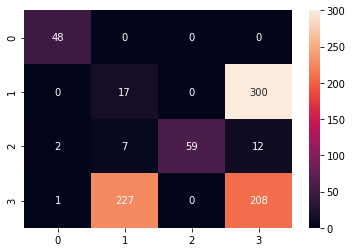

In [ ]:
random_forest = Pipeline([('cv', CountVectorizer()),
                          ('tfidf', TfidfTransformer()),
                          ('rf', RandomForestClassifier()),
])

random_forest.fit(pred_train, tar_train)

# train_predicted = RF_pipe.predict(X_train)
predictions = random_forest.predict(pred_test)

# creating confusing matrix
con_mat = confusion_matrix(tar_test,predictions)

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d')

In [ ]:
#Sacamos el índice Accuracy Score, que resume la Matriz de Confusión y la cantidad de aciertos.
print("Accuracy score: ", sklearn.metrics.accuracy_score(tar_test, predictions))

Accuracy score:  0.376844494892168


**Naive Bayes**


CONFUSION MATRIX


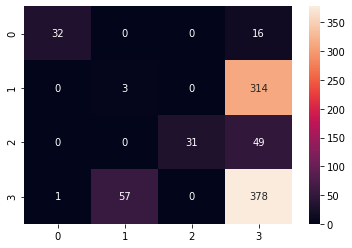

In [ ]:
naive_bayes = Pipeline([('cv', CountVectorizer()),
                        ('tfidf', TfidfTransformer()),
                        ('nb', MultinomialNB()),
])

naive_bayes.fit(pred_train, tar_train)

predictions = naive_bayes.predict(pred_test)

# creating confusing matrix

con_mat = confusion_matrix(tar_test,predictions)

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d')

In [ ]:
#Sacamos el índice Accuracy Score, que resume la Matriz de Confusión y la cantidad de aciertos.
print("Accuracy score: ", sklearn.metrics.accuracy_score(tar_test, predictions))

Accuracy score:  0.5039727582292849


Como los resultados son malos, haremos otra cosa.

Esta vez crearemos el dataset con la combinación de las 5 propiedades más comunes en cada tipo de malware, ignorando las que hemos procesado anteriormente:

In [ ]:
## Get properties of each malware type
properties_apt1 = []
properties_frecuency_apt1 = []

properties_crypto = []
properties_frecuency_crypto = []

properties_locker = []
properties_frecuency_locker = []

properties_zeus = []
properties_frecuency_zeus = []

properties_ignored = ['pe_sec_character', 'pe_sec_entropy', 'pe_sec_name', 'label', 'str']

for file in apt1_files:
  for prop in file['properties']:
    if (prop not in properties_ignored):
      if (prop not in properties_apt1):
        properties_apt1.append(prop)
        properties_frecuency_apt1.append(1)
      else:
        index = properties_apt1.index(prop)
        properties_frecuency_apt1[index] = properties_frecuency_apt1[index] + 1

for file in crypto_files:
  for prop in file['properties']:
    if (prop not in properties_ignored):
      if (prop not in properties_crypto):
        properties_crypto.append(prop)
        properties_frecuency_crypto.append(1)
      else:
        index = properties_crypto.index(prop)
        properties_frecuency_crypto[index] = properties_frecuency_crypto[index] + 1


for file in locker_files:
  for prop in file['properties']:
    if (prop not in properties_ignored):
      if (prop not in properties_locker):
        properties_locker.append(prop)
        properties_frecuency_locker.append(1)
      else:
        index = properties_locker.index(prop)
        properties_frecuency_locker[index] = properties_frecuency_locker[index] + 1
    

for file in zeus_files:
  for prop in file['properties']:
    if (prop not in properties_ignored):
      if (prop not in properties_zeus):
        properties_zeus.append(prop)
        properties_frecuency_zeus.append(1)
      else:
        index = properties_zeus.index(prop)
        properties_frecuency_zeus[index] = properties_frecuency_zeus[index] + 1


## Get common properties
properties = []
for prop in properties_apt1:
  if (prop in properties_crypto and prop in properties_locker and properties_zeus):
    properties.append(prop)

In [ ]:
# Encontrar las 5 propiedades que más se repiten en APT1
maxElements = []
most_common_properties_apt1 = []
for i in range(1, 5):
  arr = np.array(properties_frecuency_apt1)
  maxElement = np.amax(arr)
  maxElements.append(maxElement)
  ind = properties_frecuency_apt1.index(maxElement)
  properties_frecuency_apt1.pop(ind)
  most_common_properties_apt1.append(properties_apt1[ind])
  properties_apt1.pop(ind)


# Encontrar las 5 propiedades que más se repiten en crypto
maxElements = []
most_common_properties_crypto = []
for i in range(1, 5):
  arr = np.array(properties_frecuency_crypto)
  maxElement = np.amax(arr)
  maxElements.append(maxElement)
  ind = properties_frecuency_crypto.index(maxElement)
  properties_frecuency_crypto.pop(ind)
  most_common_properties_crypto.append(properties_crypto[ind])
  properties_crypto.pop(ind)


# Encontrar las 5 propiedades que más se repiten en locker
maxElements = []
most_common_properties_locker = []
for i in range(1, 5):
  arr = np.array(properties_frecuency_locker)
  maxElement = np.amax(arr)
  maxElements.append(maxElement)
  ind = properties_frecuency_locker.index(maxElement)
  properties_frecuency_locker.pop(ind)
  most_common_properties_locker.append(properties_locker[ind])
  properties_locker.pop(ind)


# Encontrar las 5 propiedades que más se repiten en zeus
maxElements = []
most_common_properties_zeus = []
for i in range(1, 5):
  arr = np.array(properties_frecuency_zeus)
  maxElement = np.amax(arr)
  maxElements.append(maxElement)
  ind = properties_frecuency_zeus.index(maxElement)
  properties_frecuency_zeus.pop(ind)
  most_common_properties_zeus.append(properties_zeus[ind])
  properties_zeus.pop(ind)  

In [ ]:
# Obtener un array con todas las propiedades más comunes
properties = []
for prop in most_common_properties_apt1:
  if (prop not in properties):
    properties.append(prop)

for prop in most_common_properties_crypto:
  if (prop not in properties):
    properties.append(prop)

for prop in most_common_properties_locker:
  if (prop not in properties):
    properties.append(prop)

for prop in most_common_properties_zeus:
  if (prop not in properties):
    properties.append(prop)


In [ ]:
print("Number of APT1 files properties: ", len(properties_apt1))
print("APT1 files properties: ", properties_apt1)
print("APT1 files frecuency properties: ", properties_frecuency_apt1)
print("APT1 files most common properties: ", most_common_properties_apt1)
print("\n")
print("Number of Crypto files properties: ", len(properties_crypto))
print("Crypto files properties: ", properties_crypto)
print("Crypto files frecuency properties: ", properties_frecuency_crypto)
print("Crypto files most common properties: ", most_common_properties_crypto)
print("\n")
print("Number of Locker files properties: ", len(properties_locker))
print("Locker files properties: ", properties_locker)
print("Locker files frecuency properties: ", properties_frecuency_locker)
print("Locker files most common properties: ", most_common_properties_locker)
print("\n")
print("Number of Zeus files properties: ", len(properties_zeus))
print("Zeus files properties: ", properties_zeus)
print("Zeus files frecuency properties: ", properties_frecuency_zeus)
print("Zeus files most common properties: ", most_common_properties_zeus)
print("\n\n")
print("Number of common properties: ", len(properties))
print("Common properties: ", properties)

Number of APT1 files properties:  50
APT1 files properties:  ['sig_antimalware_metascan', 'sig_antivirus_virustotal', 'sig_modify_proxy', 'file_write', 'net_dns', 'sig_clamav', 'sig_fraudguard_threat_intel_api', 'reg_write', 'file_read', 'api_resolv', 'file_drop', 'mutex_access', 'sig_origin_resource_langid', 'sig_static_pe_anomaly', 'sig_network_http', 'sig_stealth_window', 'cmd_exec', 'net_con', 'sig_persistence_autorun', 'sig_stealth_timeout', 'sig_copies_self', 'net_http', 'sig_dropper', 'sig_origin_langid', 'sig_reads_self', 'reg_delete', 'sig_multiple_useragents', 'file_delete', 'sig_injection_rwx', 'sig_antisandbox_sleep', 'sig_deletes_self', 'sig_packer_entropy', 'sig_packer_vmprotect', 'sig_stealth_network', 'sig_network_cnc_http', 'sig_stealth_file', 'sig_office_security', 'service_create', 'service_start', 'sig_bypass_firewall', 'sig_antiav_servicestop', 'sig_recon_beacon', 'sig_process_interest', 'sig_antivm_generic_disk', 'sig_modifies_certs', 'sig_encrypted_ioc', 'sig_exe

In [ ]:
## create dataset
dataset = [['pe_imports', 'reg_access', 'reg_read', 'file_access', 'sig_antivirus_virustotal','api_resolv', 'file_read', 'sig_injection_rwx', 'label']]

En este primer caso, probaremos a guardar en el dataset la longitud de cada una de las propiedades.

In [ ]:
def append_file(file, target):
  row = []
  
  # properties
  for prop in properties:
    if prop in file['properties']:
      row.append(len(file['properties'][prop]))
    else: row.append(0)


  # target
  row.append(target)

  dataset.append(row)

In [ ]:
for file in apt1_files:
  append_file(file, 0)

for file in crypto_files:
  append_file(file, 1)

for file in locker_files:
  append_file(file, 2)

for file in zeus_files:
  append_file(file, 3)
  

with open('malware_dataset.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for row in dataset: 
      writer.writerow(row)

In [ ]:
df = pd.read_csv("/content/malware_dataset.csv")
df.head()

,pe_imports,reg_access,reg_read,file_access,sig_antivirus_virustotal,api_resolv,file_read,sig_injection_rwx,label
0,917,4913,2699,107,440,332,80,0,0
1,926,4931,2717,107,449,350,80,0,0
2,620,0,0,0,422,0,0,0,0
3,710,359,161,107,0,125,53,0,0
4,737,359,125,215,422,152,80,0,0


In [ ]:
print(df.label.value_counts())

3    2159
1    1520
2     431
0     292
Name: label, dtype: int64


In [ ]:
predictors = df[['pe_imports', 'reg_access', 'reg_read', 'file_access', 'sig_antivirus_virustotal', 'api_resolv', 'file_read','sig_injection_rwx']]
target = df.label

target.unique()

pred_train, pred_test, tar_train, tar_test = train_test_split(predictors, target,  test_size=.2)

**Random Forest**

CONFUSION MATRIX


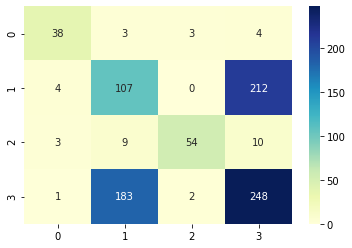

In [ ]:
classifier = RandomForestClassifier()
classifier = classifier.fit(pred_train, tar_train)

#Predecimos para los valores del grupo Test
predictions=classifier.predict(pred_test)

# creating confusing matrix
from sklearn.metrics import confusion_matrix
con_mat = confusion_matrix(tar_test,predictions)


print('CONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [ ]:
#Sacamos el índice Accuracy Score, que resume la Matriz de Confusión y la cantidad de aciertos.
print("Accuracy score: ", sklearn.metrics.accuracy_score(tar_test, predictions))

Accuracy score:  0.5073779795686719


**Naive Bayes**

In [ ]:
predictors = df[['pe_imports', 'reg_access', 'reg_read', 'file_access', 'sig_antivirus_virustotal', 'api_resolv', 'file_read','sig_injection_rwx']]
target = df.label

target.unique()

pred_train, pred_test, tar_train, tar_test = train_test_split(predictors, target,  test_size=.2)

CONFUSION MATRIX


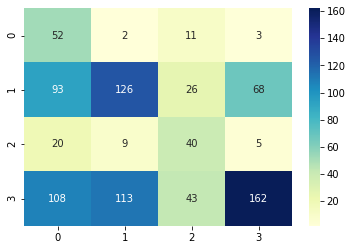

In [ ]:
classifier = MultinomialNB()
classifier = classifier.fit(pred_train, tar_train)

#Predecimos para los valores del grupo Test
predictions=classifier.predict(pred_test)

# creating confusing matrix
from sklearn.metrics import confusion_matrix
con_mat = confusion_matrix(tar_test,predictions)


print('CONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [ ]:
#Sacamos el índice Accuracy Score, que resume la Matriz de Confusión y la cantidad de aciertos.
print("Accuracy score: ", sklearn.metrics.accuracy_score(tar_test, predictions))

Accuracy score:  0.43132803632236094


Los resultados siguen siendo pésimos. Lo que haremos ahora será crear un único string con todas las propiedades que hemos obtenido anteriormente: 'pe_imports', 'reg_access', 'reg_read', 'file_access', 'file_access', 'api_resolv', 'sig_injection_rwx'.

In [ ]:
properties

['pe_imports',
 'reg_access',
 'reg_read',
 'file_access',
 'sig_antivirus_virustotal',
 'api_resolv',
 'file_read',
 'sig_injection_rwx']

In [ ]:
## create dataset
dataset = [['properties', 'label']]

def append_file(file, target):
  row = []
  string = '0'
  
  # properties
  for prop in properties:
    if prop in file['properties']:
      string = string + file['properties'][prop]

  row.append(string)


  # target
  row.append(target)

  dataset.append(row)

In [ ]:
for file in apt1_files:
  append_file(file, 0)

for file in crypto_files:
  append_file(file, 1)

for file in locker_files:
  append_file(file, 2)

for file in zeus_files:
  append_file(file, 3)
  

with open('malware_dataset.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for row in dataset: 
      writer.writerow(row)

In [ ]:
df = pd.read_csv("/content/malware_dataset.csv")
df.head()

,properties,label
0,09e49750e 9d47863c dd50ea4c f659f996 a2d78c4b ...,0
1,09e49750e 9d47863c dd50ea4c f659f996 a2d78c4b ...,0
2,0971d2c25 a405bc49 35b3913c 9492b793 e9b9792a ...,0
3,0d77083a7 57b32fd5 268d42b1 93288686 dc11a7db ...,0
4,0839ca61c 2b78df95 7f8fa70c 69fe6141 d77083a7 ...,0


In [ ]:
predictors = df.properties
target = df.label

target.unique()

pred_train, pred_test, tar_train, tar_test = train_test_split(predictors, target,  test_size=.2)

**Random forest**


CONFUSION MATRIX


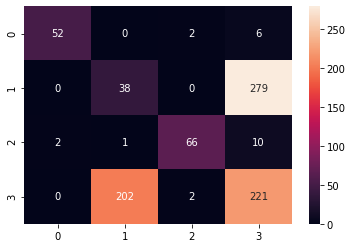

In [ ]:
random_forest = Pipeline([('cv', CountVectorizer()),
                          ('tfidf', TfidfTransformer()),
                          ('rf', RandomForestClassifier(n_estimators=10)),
])

random_forest.fit(pred_train, tar_train)

# train_predicted = RF_pipe.predict(X_train)
predictions = random_forest.predict(pred_test)

# creating confusing matrix
con_mat = confusion_matrix(tar_test,predictions)

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d')

In [ ]:
#Sacamos el índice Accuracy Score, que resume la Matriz de Confusión y la cantidad de aciertos.
print("Accuracy score: ", sklearn.metrics.accuracy_score(tar_test, predictions))

Accuracy score:  0.4279228149829739


**Naive Bayes**


CONFUSION MATRIX


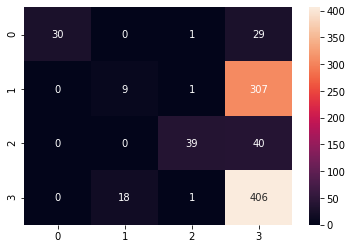

In [ ]:
naive_bayes = Pipeline([('cv', CountVectorizer()),
                        ('tfidf', TfidfTransformer()),
                        ('nb', MultinomialNB()),
])

naive_bayes.fit(pred_train, tar_train)

# train_predicted = RF_pipe.predict(X_train)
predictions = naive_bayes.predict(pred_test)

# creating confusing matrix

con_mat = confusion_matrix(tar_test,predictions)

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d')

In [ ]:
#Sacamos el índice Accuracy Score, que resume la Matriz de Confusión y la cantidad de aciertos.
print("Accuracy score: ", sklearn.metrics.accuracy_score(tar_test, predictions))

Accuracy score:  0.5493757094211124
